# source: [Ethereum Historical data](https://www.kaggle.com/datasets/themrityunjaypathak/ethereum-historical-data)

### Lib imports 

In [31]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates

from datetime import date, timedelta, datetime # Date Functions

import tensorflow as tf 
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training

from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 

import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})


# for reproducibility; set the following seeds (note, that the results may still vary slightly. Also, the stock data is is up to the latest date, so the results may vary slightly over time)
np.random.seed(1)
tf.random.set_seed(1)

## Load source data: [source link](https://www.kaggle.com/datasets/themrityunjaypathak/ethereum-historical-data)

In [32]:
url = f"https://raw.githubusercontent.com/dsirepos/data/main/ethereum_price.csv"
df = pd.read_csv(url)

In [33]:
# info about data 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2555 entries, 0 to 2554
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2555 non-null   object
 1   Price     2555 non-null   object
 2   Open      2555 non-null   object
 3   High      2555 non-null   object
 4   Low       2555 non-null   object
 5   Vol.      2555 non-null   object
 6   Change %  2555 non-null   object
dtypes: object(7)
memory usage: 139.9+ KB


## Data Pre-processing 

In [35]:
# column name Fix  : vol. , change %

df.columns= [x.lower().strip().replace(' ', '_') for x in df.columns]

df = df.rename(columns={'vol.' : 'volume', "change_%" : "percentage_change"})
df.columns

Index(['date', 'price', 'open', 'high', 'low', 'volume', 'percentage_change'], dtype='object')

In [36]:
# dype change 

df['date'] = pd.to_datetime(df.date)

df.head()

,date,price,open,high,low,volume,percentage_change
0,2023-03-08,"1,553.49","1,561.79","1,569.70","1,548.98",498.57K,-0.53%
1,2023-03-07,"1,561.78","1,565.84","1,580.95","1,536.31",460.10K,-0.26%
2,2023-03-06,"1,565.84","1,564.36","1,581.13","1,555.43",322.16K,0.09%
3,2023-03-05,"1,564.37","1,566.73","1,587.95","1,556.84",313.01K,-0.15%
4,2023-03-04,"1,566.73","1,569.45","1,577.02","1,550.10",247.02K,-0.14%


In [37]:
df['price'] = df['price'].str.replace(',' , '')
df['open'] = df['open'].str.replace(',', '')
df['high'] = df['high'].str.replace(',', '')
df['low'] = df['low'].str.replace(',', '')

df['percentage_change'] = df['percentage_change'].str.replace('%', '')

def normalize_volume(vol):
    if vol[-1] == 'K':
        return float(vol[:-1]) * 1000
    elif vol[-1] == 'M':
        return float(vol[:-1]) * 1_000_000
    elif vol[-1] == 'B':
        return float(vol[:-1]) * 1_000_000_000
    elif vol == '-':
        return np.NaN
    else:
        return float(vol)


df['volume'] = df['volume'].apply(normalize_volume)



df.head()

,date,price,open,high,low,volume,percentage_change
0,2023-03-08,1553.49,1561.79,1569.70,1548.98,498570.0,-0.53
1,2023-03-07,1561.78,1565.84,1580.95,1536.31,460100.0,-0.26
2,2023-03-06,1565.84,1564.36,1581.13,1555.43,322160.0,0.09
3,2023-03-05,1564.37,1566.73,1587.95,1556.84,313010.0,-0.15
4,2023-03-04,1566.73,1569.45,1577.02,1550.10,247020.0,-0.14


In [38]:
_ = df.isna().sum()
_.head()

date     0
price    0
open     0
high     0
low      0
dtype: int64

## Missing data

In [39]:
_ = df.query('volume.isnull()')
_.head()

,date,price,open,high,low,volume,percentage_change
1928,2017-11-26,464.00,464.00,464.00,464.00,NaN,0.00
2402,2016-08-09,10.16,10.16,10.16,10.16,NaN,0.00
2403,2016-08-08,10.16,10.16,10.16,10.16,NaN,0.00
2404,2016-08-07,10.16,10.16,10.16,10.16,NaN,0.00
2405,2016-08-06,10.16,10.16,10.16,10.16,NaN,0.00


In [40]:
# imputing with interpolated data ( makes assumptions based on the neighbouring non null values ).

df['volume'] = df['volume'].interpolate(method='linear')


In [41]:
# set date as index 

df = df.sort_values(by=['date'])
df = df.set_index('date')



In [42]:
df.head()

,price,open,high,low,volume,percentage_change
date,,,,,,
2016-03-10,11.75,11.20,11.85,11.07,0.0,4.91
2016-03-11,11.95,11.75,11.95,11.75,180.0,1.70
2016-03-12,12.92,11.95,13.45,11.95,830.0,8.12
2016-03-13,15.07,12.92,15.07,12.92,1300.0,16.64
2016-03-14,12.50,15.07,15.07,11.40,92180.0,-17.05


##  dtypes conversion 

In [43]:
for column in df.columns:
    df[column] =df[column].astype('float')
    

In [44]:
df.dtypes

price                float64
open                 float64
high                 float64
low                  float64
volume               float64
percentage_change    float64
dtype: object

In [45]:
df.shape

(2555, 6)

## visualize the recent stock data 

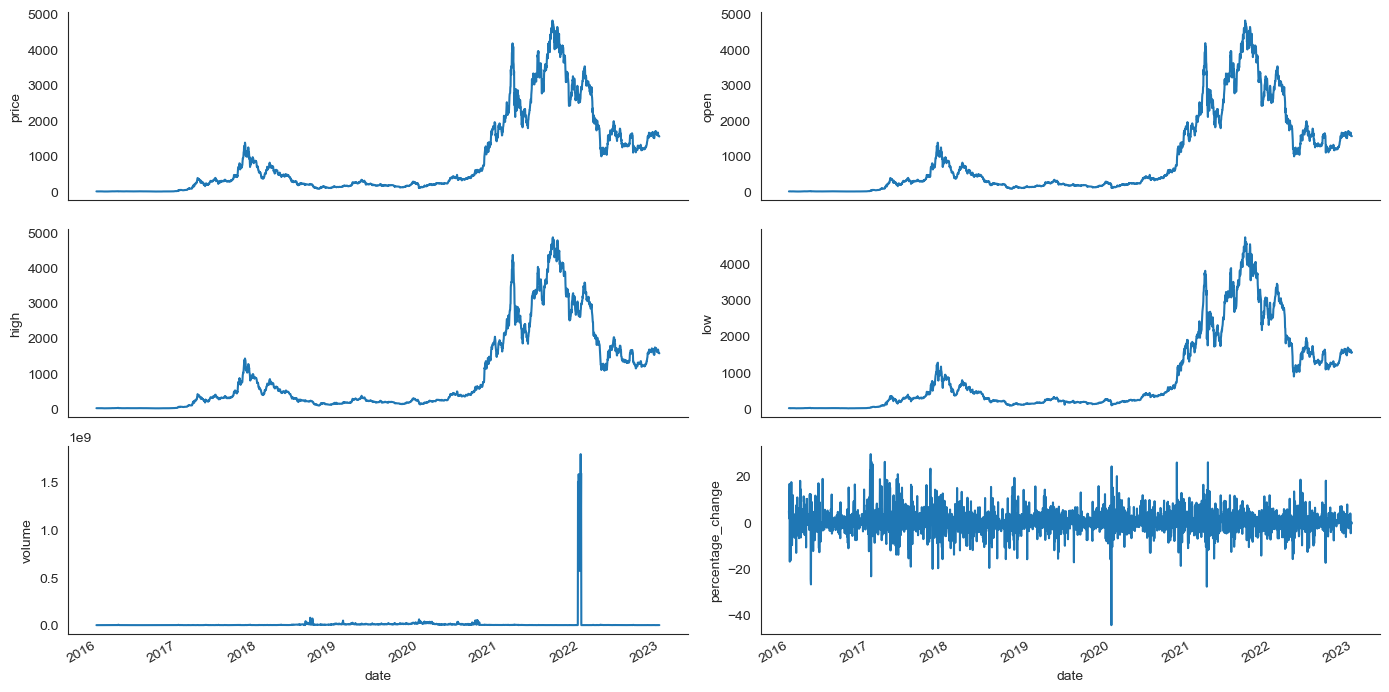

In [46]:
ncols = 2
nrows = math.ceil(df.shape[1] / ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7)) # sharex allows for all subplots to have the same x-axis
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)  # plot the i-th column of the dataframe
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator()) # AutoDateFormatter class figures out the best format to use for the date
fig.tight_layout()
plt.show()

## Addressing Scale difference

In [47]:
from sklearn.preprocessing import MinMaxScaler

TARGET = 'open'
FEATURES = list(df.columns)
FEATURES.remove(TARGET)

X = df[FEATURES]
y = df[TARGET]


In [48]:

# Transform the data by scaling each feature to a range between 0 and 1
scaler_features = MinMaxScaler()
scaler_pred = MinMaxScaler()

X_scaled = scaler_features.fit_transform(X)
y_scaled  = scaler_pred.fit_transform(y.values.reshape(-1, 1))

In [49]:
np_data = np.column_stack((X_scaled, y_scaled))
np_data.shape

(2555, 6)

In [123]:
df = pd.DataFrame(np_data, columns=df.columns, index=df.index)

df.to_parquet('trained_set.parquet')

## reshape source data 

In [94]:

sequence_length  = 1

index_open = df.columns.get_loc("open") # returns the index of the Close column
print("Index open: " + str(index_open))

def partition_dataset(sequence_length, data):
    x, y = [],[]
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columns
        y.append(data[i, index_open]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    x = np.delete(x, index_open, 2) #delete the Close column in the 3d array (delete index_Close column in the 2nd dimension)
    y = np.array(y)
    return x, y

# Generate training data and test data
X, y = partition_dataset(sequence_length, np_data)

Index open: 1


## train test split 

In [95]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, shuffle=False)

In [96]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2043, 1, 5) (2043,)
(511, 1, 5) (511,)


In [97]:
from keras.optimizers import Adam
import tensorflow as tf

# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False )) 
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation=None))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='mse'
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               42400     
                                                                 
 dense_4 (Dense)             (None, 5)                 505       
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 42,911
Trainable params: 42,911
Non-trainable params: 0
_________________________________________________________________


In [98]:
# Training the model
epochs = 50 # should be at least 50, but it takes a long time to train. 
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(
        X_train, y_train, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=[early_stop]
)

Epoch 1/50
128/128 [==============================] - 3s 6ms/step - loss: 0.0030 - val_loss: 6.4382e-04
Epoch 2/50
128/128 [==============================] - 0s 3ms/step - loss: 1.3130e-04 - val_loss: 3.5958e-04
Epoch 3/50
128/128 [==============================] - 0s 3ms/step - loss: 1.0932e-04 - val_loss: 4.1585e-04
Epoch 4/50
128/128 [==============================] - 0s 3ms/step - loss: 1.0696e-04 - val_loss: 0.0022
Epoch 5/50
128/128 [==============================] - 0s 3ms/step - loss: 1.3491e-04 - val_loss: 5.3411e-04
Epoch 6/50
128/128 [==============================] - 0s 3ms/step - loss: 1.2242e-04 - val_loss: 9.9708e-04
Epoch 7/50
128/128 [==============================] - 0s 3ms/step - loss: 1.3937e-04 - val_loss: 5.2835e-04
Epoch 8/50
128/128 [==============================] - 0s 3ms/step - loss: 1.3289e-04 - val_loss: 5.1363e-04
Epoch 9/50
128/128 [==============================] - 0s 3ms/step - loss: 1.2514e-04 - val_loss: 6.9011e-04
Epoch 9: early stopping


## model performance 

In [99]:
# Get the predicted values
y_pred = model.predict(X_test)
y_pred.shape
# # Unscale the predicted values
y_pred_unscaled = scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

16/16 [==============================] - 0s 1ms/step


In [100]:
y_pred_unscaled.shape, y_test_unscaled.shape

((511, 1), (511, 1))

In [101]:

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 74.58
Mean Absolute Percentage Error (MAPE): 2.83 %
Median Absolute Percentage Error (MDAPE): 1.72 %


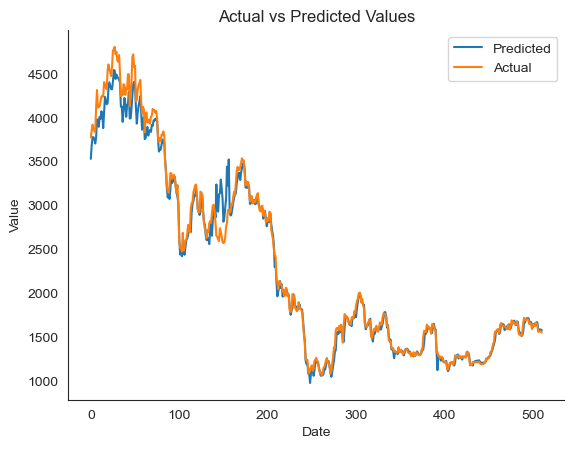

In [107]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the predicted values
ax.plot(y_pred_unscaled, label='Predicted')

# Plot the actual values
ax.plot( y_test_unscaled, label='Actual')

# Set the plot title and axis labels
ax.set_title("Actual vs Predicted Values")
ax.set_xlabel("Date")
ax.set_ylabel("Value")

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


## save model

In [108]:
model.save("eth_lstm_model.h5")
model.save_weights('eth_lstm_weights.h5')

## load model

In [109]:
from keras.models import load_model

loaded_model = load_model('eth_lstm_model.h5')
loaded_model.load_weights('eth_lstm_weights.h5')

## New prediction

In [110]:
list(df.index)[-1]

Timestamp('2023-03-08 00:00:00')

In [111]:

# Start and end dates
start_date = '2023-03-01'
end_date = '2023-03-08'

# Check if start and end dates are within DataFrame index
while start_date not in df.index or end_date not in df.index:
    start_date = pd.to_datetime(start_date) - pd.DateOffset(years=1)
    end_date = pd.to_datetime(end_date) - pd.DateOffset(years=1)

print("Updated start date:", start_date)
print("Updated end date:", end_date)


Updated start date: 2023-03-01
Updated end date: 2023-03-08


In [115]:
df_new = df[start_date:end_date]

df_new.shape

(8, 6)

In [119]:
X,y = partition_dataset(1, df_new.to_numpy())
X.shape

(7, 1, 5)

In [120]:
y_pred = loaded_model.predict(X)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y.reshape(-1, 1))



1/1 [==============================] - 0s 346ms/step


In [121]:
y_pred.shape

(7, 1)

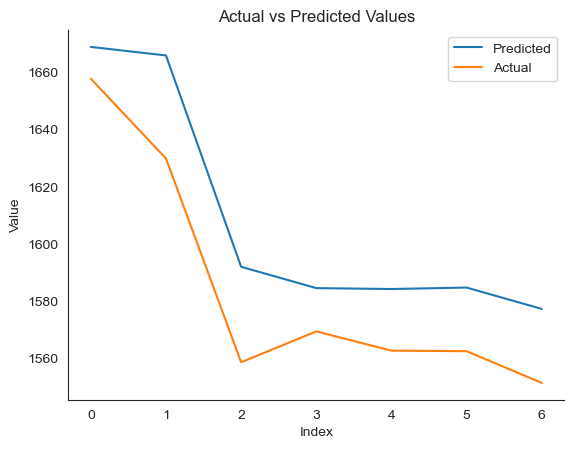

In [122]:


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the predicted values
ax.plot(y_pred_unscaled, label='Predicted')

# Plot the actual values
ax.plot(y_test_unscaled, label='Actual')

# Set the plot title and axis labels
ax.set_title("Actual vs Predicted Values")
ax.set_xlabel("Index")
ax.set_ylabel("Value")

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()
